In [1]:
%load_ext autoreload
%autoreload 2
import config as cfg
from sca import plots, helpers as h

In [6]:
import numpy as np
X, y, *_ = h.load_data("data/raw/ascadv.h5")
print(f"NaN present in X: {np.isnan(X).any().any()}")

NaN present in X: False


Dataset zawiera 300 000 próbek (200 000 w zbiorze treningowym + 100 000 w zbiorze testowym). Użyta przeze mnie wersja to wycięte *okno zainteresowania* (tzw. *ślad* o długości 1400 próbek), w którym procesor wykonuje operację [S-box](../SBOX.md). Zbiór ten jest powszechnie stosowany jako benchmark dla modeli uczenia głębokiego, jednak celem mojego projektu jest weryfikacja wyników osiągalnych przy użyciu klasycznego uczenia maszynowego.

Każda próbka w śladzie reprezentuje amplitudę pola elektromagnetycznego zmierzoną oscyloskopem w konkretnym cyklu zegara procesora (wartości znormalizowane w zakresie od -128 do 127). Tak wyglądają próbki dla klas 0x00 i 0xFF:

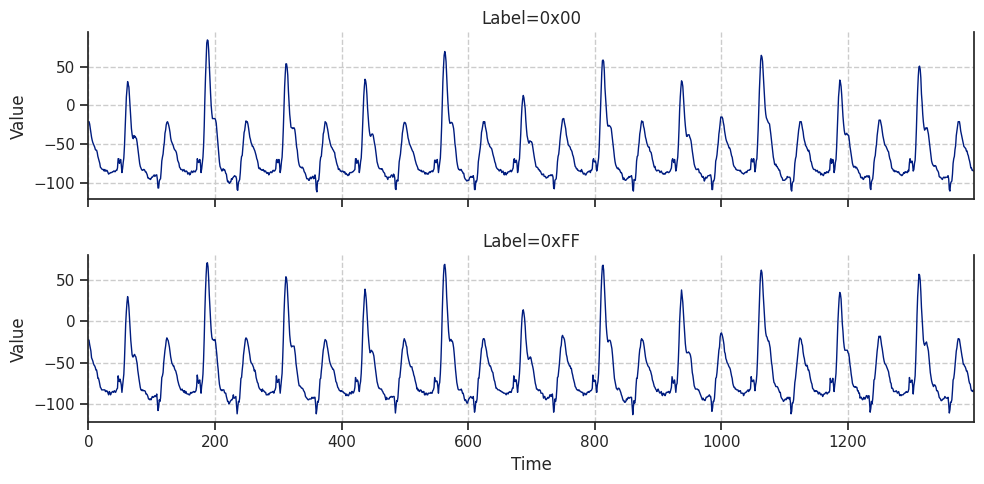

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')
sns.set_palette('dark')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

trace_0x00 = plots.sample_trace(X, y, byte_val=0x00, seed=SEED)
plots.labs(sns.lineplot(trace_0x00, linewidth=1, ax=ax1), 
           title="Label=0x00", ylab="Value")
plots.lim(ax1, len(trace_0x00)).grid(True, linestyle='--')

trace_0xFF = plots.sample_trace(X, y, byte_val=0xFF, seed=SEED)
plots.labs(sns.lineplot(trace_0xFF, linewidth=1, ax=ax2), 
           title="Label=0xFF", xlab="Time", ylab="Value")
plots.lim(ax2, len(trace_0xFF)).grid(True, linestyle='--')

fig.tight_layout(h_pad=1.5)
sns.despine(fig=fig, right=False)
fig.savefig("figures/sample_traces.png", dpi=300)

Każdy "pik" reprezentuje skok poboru mocy podczas ładowania danych do rejestru (ładnie widać poszczególne cykle procesora). Wg. opisu datasetu dane sa zsynchronizowane, więc każdy punkt w czasie można traktować również jako cechę, co w tym przypadku sprowadza zadanie do zwykłej klasyfikacji. 

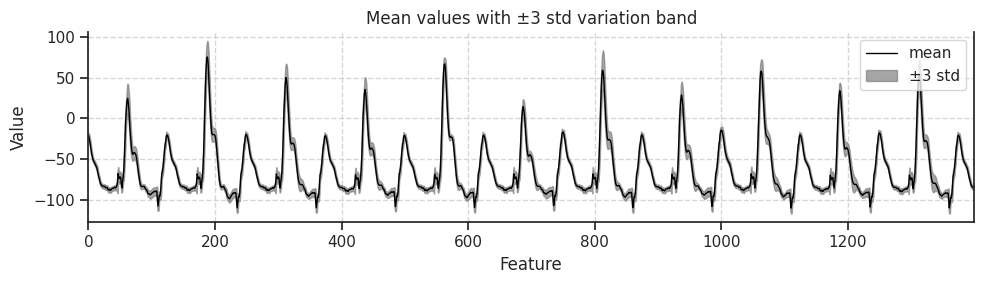

In [49]:
fig, ax = plt.subplots(figsize=(10, 3))
m, sd = plots.mean_std(X)

ax.plot(range(len(m)), m, linewidth=1, color="black", label="mean")
plots.labs(plots.lim(ax, len(m)), xlab="Feature", ylab="Value", 
           title=f"Mean values with ±3 std variation band")
plots.std_band(ax, m, sd).grid(True, linestyle="--", alpha=0.8)
ax.legend(loc='upper right')

sns.despine(fig=fig, right=False)
fig.tight_layout()
fig.savefig("figures/mean_trace_with_sd.png")

Widać, że punkty w podobnych momentach cyklu są silnie skorelowane:

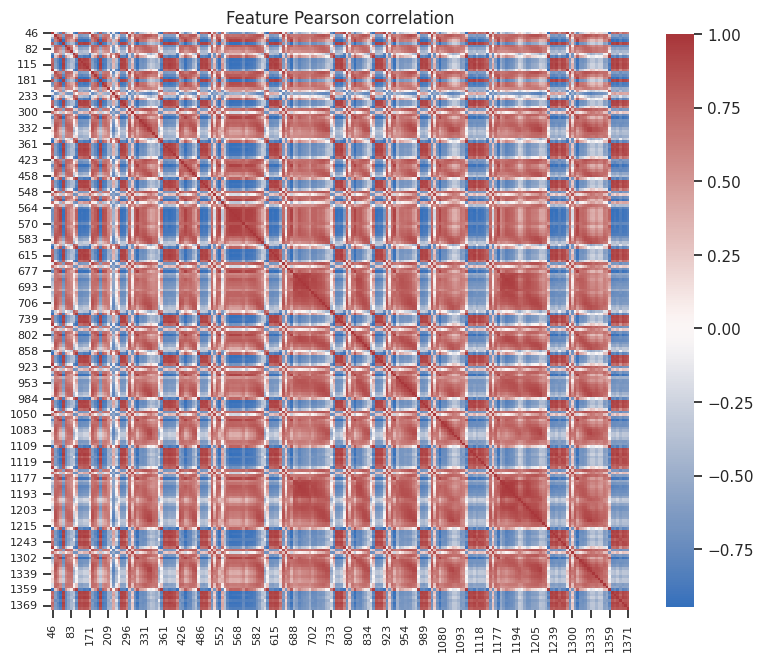

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(plots.filtered_corr(X), cmap="vlag", center=0, 
            square=True, ax=ax, cbar_kws={'shrink': 0.75})
plots.labs(ax, title="Feature Pearson correlation")
plots.ticklabsp(ax, 'x', rot=90, fs=8)
plots.ticklabsp(ax, 'y', rot=0, fs=8)

fig.tight_layout()
fig.savefig("figures/feature_pearson.png", dpi=300)

W celu utrudnienia ataku mikrokontroler stosuje metodę zwaną *maskingiem*. Polega ona na dodaniu losowej maski $r_{in}$ do wartości $d \oplus k$ i skonstruowaniu tymczasowej tabeli $\mathrm{Sbox}'$, która ma za zadanie kompensować maskę $r_{in}$ na wejściu i dodać nową losową maskę $r_{out}$ na wyjściu:

$$
z' = \mathrm{Sbox}'((d \oplus k) \oplus r_{in}) \oplus r_{out}
$$

Dzięki temu zabiegowi zarówno szyna adresowa, jak i szyna danych są zabezpieczone, ponieważ z punktu widzenia zewnętrznego obserwatora wartości te wyglądają jak prawie losowy szum. Ani niezemaskowana wartość $d \oplus k$, ani czysty wynik $z$ nie pojawiają się w żadnym momencie w rejestrze procesora. Obserwując losową zmienną $X$ (jakiś punkt w czasie) będziemy widzieć splot jednostajnego rozkładu maski z szumem elektronicznym (który ma rozkład normalny).

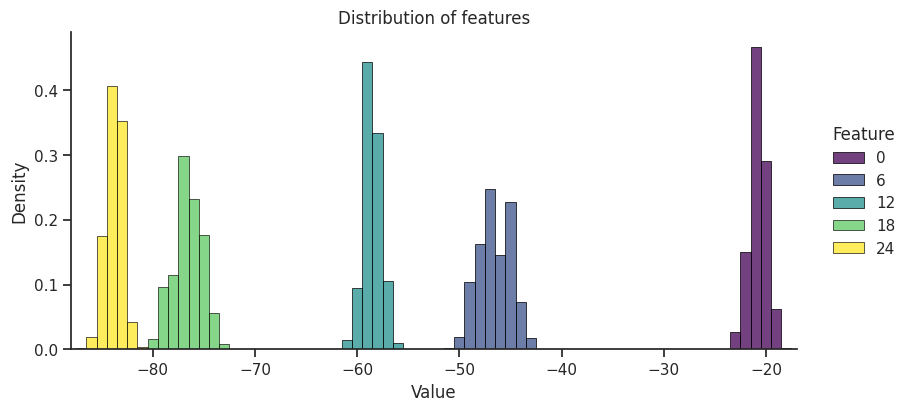

In [5]:
ax = plots.features_hist(X, idx=range(0, 30, 6), figsize=(9, 4))
ax.figure.savefig("figures/feature_hist.png", dpi=300)

Niestety, ciężko wykonać jakikolwiek test normalności dla tak dużej liczby obserwacji, tym bardziej że dane są skwantyzowane. Sprawdzę, jak wygląda rozkład skosu i kurtozy, i czy są wystarczające żeby uznać rozkład w przybliżeniu za normalny.

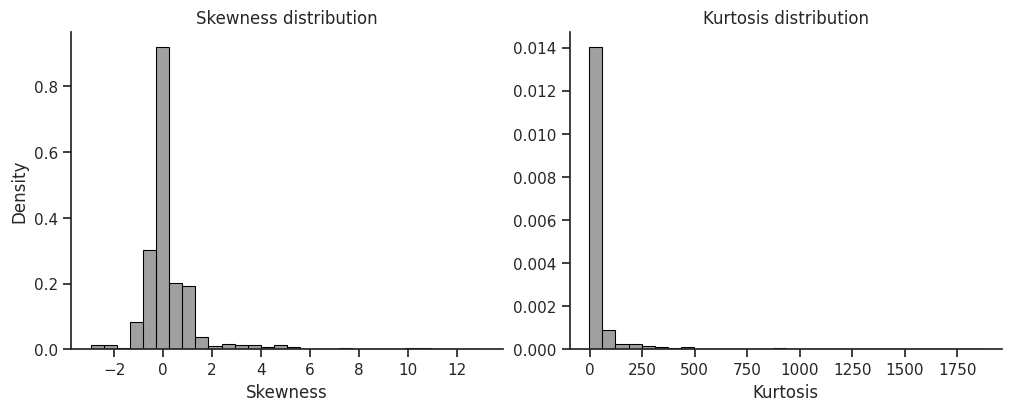

In [6]:
fig = plots.dist_plots(X)
fig.savefig("figures/feature_dist.png", dpi=300)

Jak oczekiwałem, skos i kurtoza gromadzą się wokół zera.

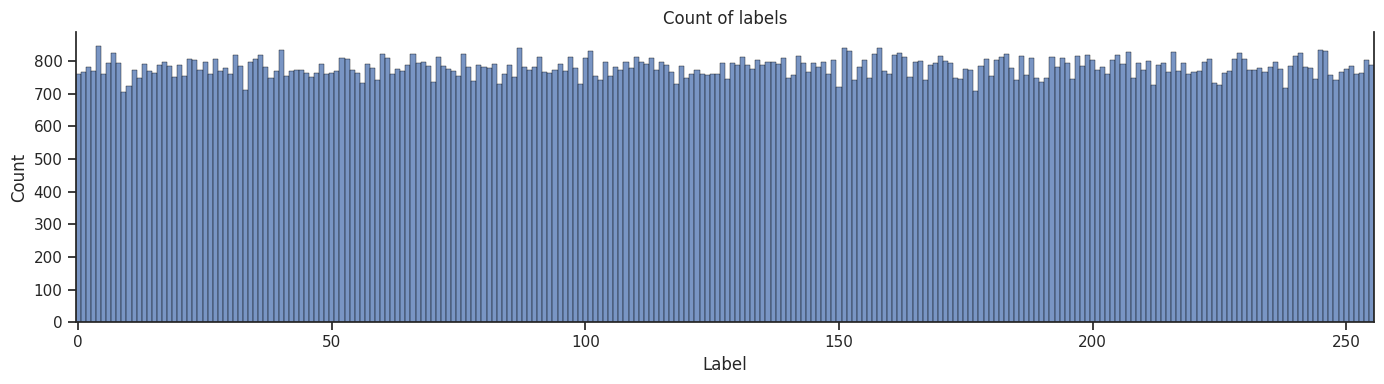

In [182]:
fig = plots.class_hist(y)
fig.savefig("figures/class_hist.png", dpi=300)

Na powyższym wykresie widać, że klasy są zbalansowane

In [ ]:
hw = np.bitwise_count(y)
corr = np.corrcoef(pd.concat([X, pd.DataFrame([y])]))